In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
X_sales = pd.read_csv('data/상권_clusters.csv', encoding='cp949')

In [4]:
X_sales.head()

,상권_코드,2019-Q4,2020-Q1,2020-Q2,2020-Q3,2020-Q4,2021-Q1,2021-Q2,2021-Q3,2021-Q4,2022-Q1,2022-Q2,2022-Q3,2022-Q4,y_pred_3_euc,y_pred_4_euc,y_pred_6_euc,y_pred_3_dtw,y_pred_4_dtw,y_pred_6_dtw
0,3110001,0.0,-0.073992,0.037308,-0.020321,0.003290,-0.057947,0.004617,-0.027532,0.019208,-0.025525,0.067276,-0.049308,0.016183,1,1,1,0,1,0
1,3110002,0.0,-0.060906,-0.108002,-0.115149,-0.106439,-0.123700,-0.127102,-0.124724,-0.062470,-0.115464,-0.107648,-0.058126,-0.073964,2,2,2,2,2,2
2,3110003,0.0,-0.073611,-0.050442,-0.085279,-0.095606,-0.102475,-0.083452,-0.110136,0.066021,-0.006563,0.013796,0.001643,0.157614,1,3,3,2,0,5
3,3110004,0.0,-0.193832,-0.150971,-0.136135,-0.117578,-0.034334,0.001848,-0.031015,-0.110403,-0.123919,0.041367,-0.070495,-0.036907,1,1,1,0,0,5
4,3110005,0.0,-0.039573,-0.021717,0.007646,0.005814,-0.039181,0.030157,-0.008742,0.084164,-0.019583,0.051530,0.031802,0.063721,1,3,1,0,0,0


In [5]:
TARGET_DATES = ["2019-Q4"] + [f"{year}-Q{quarter}" for year in range(2020, 2022) for quarter in range(1, 5)]
# 거리두기 철폐시점까지
COVID_DATES = ["2020-Q1", "2020-Q2", "2020-Q3", "2020-Q4", "2021-Q1", "2021-Q2", "2021-Q3", "2021-Q4", "2022-Q1"]

### COVID_local_min: 코로나 중 최저 매출 시점

In [12]:
X_sales["Covid_local_min"] = X_sales[["2019-Q4"] + COVID_DATES].idxmin(axis=1) # 매출 하락 없었으면 2019-Q4

In [13]:
X_sales["Covid_local_min"].value_counts()

2021-Q1    436
2022-Q1    313
2020-Q1    155
2021-Q3    111
2020-Q4     68
2020-Q3     42
2021-Q4     39
2021-Q2     32
2019-Q4     30
2020-Q2     19
Name: Covid_local_min, dtype: int64

### t_recovery: 매출 회복 시점 (회복 못 했을 시 2022-Q4)

In [14]:
def get_interval(q_1, q_2):
    if q_1 == np.nan or q_2 == np.nan:
        return np.nan
    return (int(q_2[:4]) - int(q_1[:4])) * 4 + int(q_2[-1]) - int(q_1[-1])

In [15]:
def get_recov(row):
    END_DATE = "2022-Q4"
    for date in TARGET_DATES:
        if (get_interval(row["Covid_local_min"], date) > 0) and (row[date] > 0):
            return date
    return END_DATE

In [16]:
X_sales["t_recovery"] = X_sales.apply(lambda row: get_recov(row), axis=1)

<Axes: xlabel='t_recovery'>

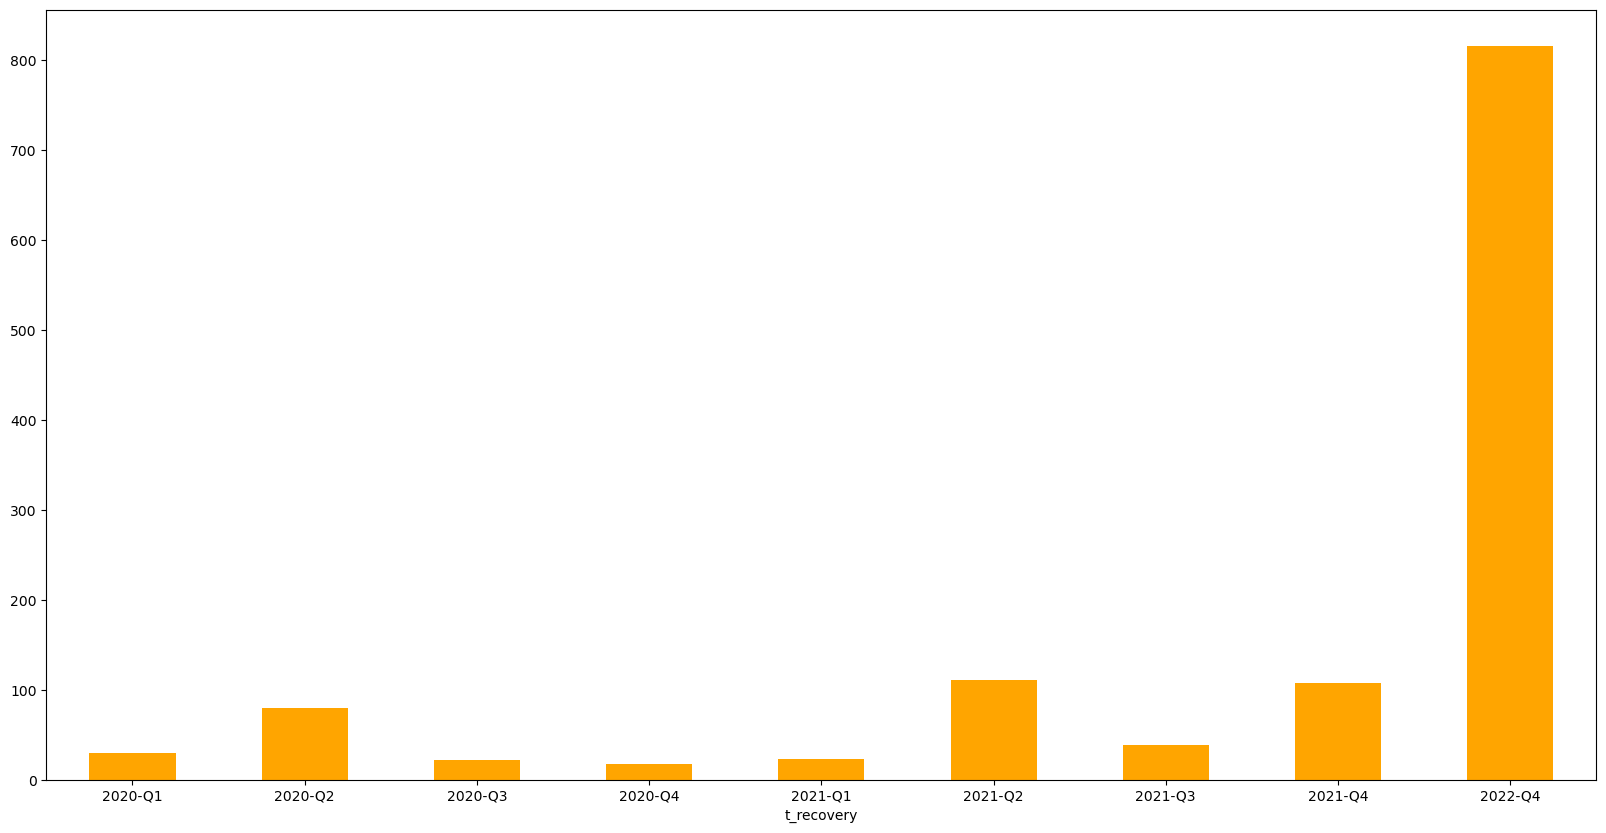

In [17]:
X_sales.groupby("t_recovery").size().plot(
    kind="bar", figsize=(20, 10), rot=0, color="orange"
)

### 소요기간

In [18]:
X_sales["d_resistance"] = X_sales.apply(
    lambda row: get_interval("2019-Q4", row["Covid_local_min"]), axis=1
)

In [19]:
X_sales["d_recovery"] = X_sales.apply(
    lambda row: get_interval(row["Covid_local_min"], row["t_recovery"]), axis=1
)

In [20]:
X_sales["d_stability"] = X_sales.apply(
    lambda row: get_interval(row["t_recovery"], "2022-Q4"), axis=1
)

## Resilience index 산출

In [21]:
X_sales["drop"] = X_sales.apply(
    lambda row: 1 - 10 ** row[row["Covid_local_min"]], axis=1
)

In [22]:
def get_rebound(row):
    res = 10 ** row[row["t_recovery"]] - 10 ** row[row["Covid_local_min"]]
    res = res / (10 ** row[row["Covid_local_min"]])
    res = res / row["d_recovery"]
    return res

In [23]:
X_sales["rebound"] = X_sales.apply(lambda row: get_rebound(row), axis=1)

In [24]:
min_rebound = X_sales["rebound"].min()
min_drop = X_sales["drop"].min()

In [25]:
def get_resilence_ratio(row):
    s = 0.001
    return np.log((row["rebound"] - min_rebound + s) / (row["drop"] - min_drop + s))

In [26]:
X_sales["res_ratio"] = X_sales.apply(lambda row: get_resilence_ratio(row), axis=1)

In [27]:
res_r_mean = X_sales["res_ratio"].mean()
res_r_std = X_sales["res_ratio"].std()

In [28]:
X_sales[X_sales["res_ratio"] > 5]

,상권_코드,2019-Q4,2020-Q1,2020-Q2,2020-Q3,2020-Q4,2021-Q1,2021-Q2,2021-Q3,2021-Q4,...,y_pred_4_dtw,y_pred_6_dtw,Covid_local_min,t_recovery,d_resistance,d_recovery,d_stability,drop,rebound,res_ratio
27,3110029,0.0,0.036202,0.034891,0.048604,0.025297,0.013438,0.019157,0.044908,0.031628,...,0,0,2019-Q4,2020-Q1,0,1,11,0.0,0.086930,5.320358
145,3110160,0.0,0.117266,0.087598,0.009190,0.043187,0.073571,0.098447,0.067533,0.085018,...,1,4,2019-Q4,2020-Q1,0,1,11,0.0,0.309984,6.057979
207,3110228,0.0,0.022480,0.052948,0.071120,0.043721,0.005404,0.020372,0.036030,0.049800,...,1,4,2019-Q4,2020-Q1,0,1,11,0.0,0.053126,5.139632
222,3110245,0.0,0.044740,0.021719,0.034168,0.005645,0.007395,0.054735,0.087735,0.049932,...,0,0,2019-Q4,2020-Q1,0,1,11,0.0,0.108511,5.420703
225,3110248,0.0,0.014017,0.204825,0.163792,0.220165,0.197151,0.202983,0.246335,0.256105,...,0,0,2019-Q4,2020-Q1,0,1,11,0.0,0.032801,5.012821
300,3110328,0.0,0.020324,0.041127,0.088341,0.044653,0.042858,0.060613,0.125073,0.090437,...,1,4,2019-Q4,2020-Q1,0,1,11,0.0,0.047911,5.108598
310,3110338,0.0,0.148059,0.262600,0.291070,0.246808,0.258806,0.233234,0.295348,0.212526,...,1,4,2019-Q4,2020-Q1,0,1,11,0.0,0.406238,6.261042
364,3110394,0.0,0.070113,0.201747,0.219093,0.102109,0.124099,0.272476,0.278903,0.173632,...,0,0,2019-Q4,2020-Q1,0,1,11,0.0,0.175205,5.679256
438,3110471,0.0,0.057754,0.102708,0.086057,0.068058,0.063939,0.091486,0.096743,0.043112,...,3,3,2019-Q4,2020-Q1,0,1,11,0.0,0.142230,5.559747
505,3110541,0.0,0.013288,0.036471,0.078969,0.017752,0.038646,0.058091,0.074829,0.050998,...,1,4,2019-Q4,2020-Q1,0,1,11,0.0,0.031070,5.001241


In [29]:
# 정규화
X_sales["resilience"] = X_sales.apply(
    lambda row: (row["res_ratio"] - res_r_mean) / res_r_std, axis=1
)

In [30]:
X_sales["resilience"].describe()

count    1.245000e+03
mean     2.853585e-18
std      1.000000e+00
min     -4.965008e+00
25%     -5.796617e-01
50%     -2.404761e-01
75%      3.709474e-01
max      5.297006e+00
Name: resilience, dtype: float64

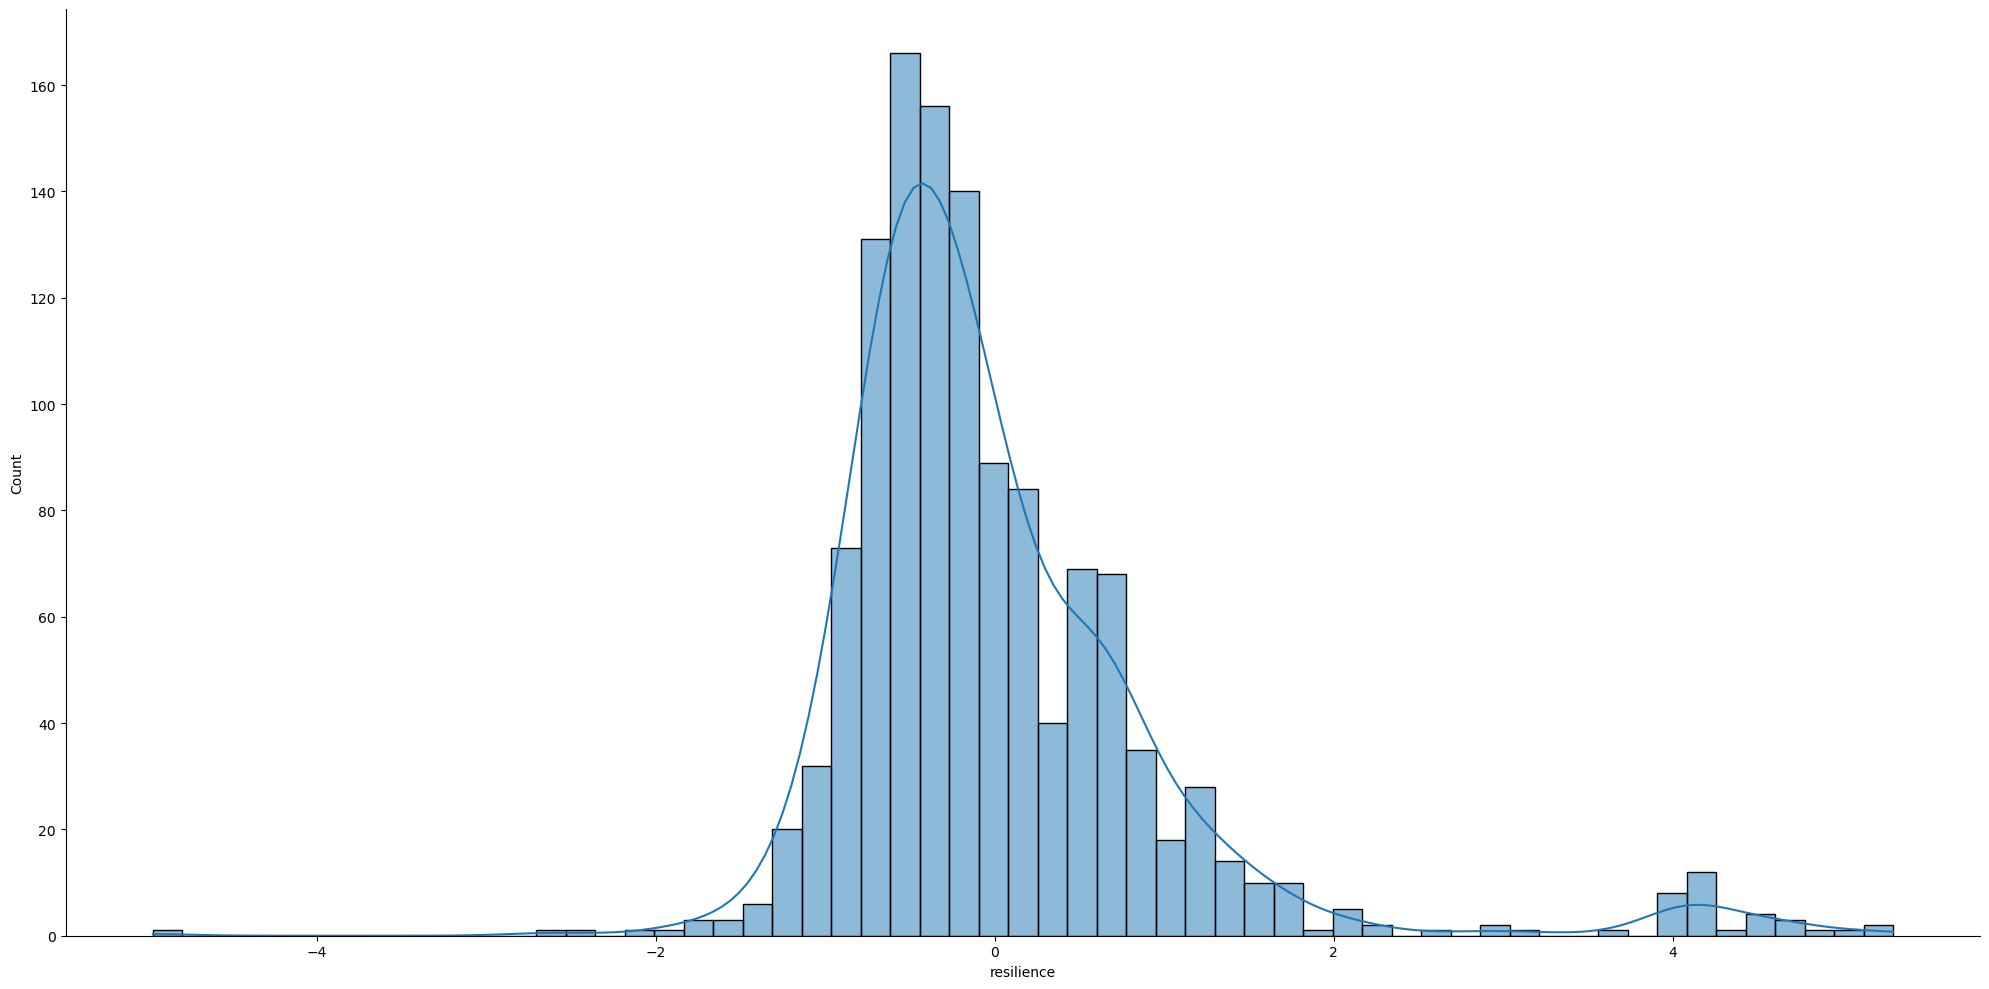

In [33]:
# Kde of resilience
sns.displot(X_sales["resilience"], kde=True, height=10, aspect=2)

In [34]:
X_sales.to_csv("data/resilience_index.csv", encoding="cp949")